In [1]:
#!pip install prince

In [2]:
#Imports
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

import seaborn as sns
import prince
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.manifold import MDS

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [3]:
#======================LOADING DATA INTO DATAFRAME====================
data = pd.read_csv('monroe-county-crash-data2003-to-2015.csv',encoding='latin1')

data.head()

,Master Record Number,Year,Month,Day,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude
0,902363382,2015,1,5,Weekday,0.0,2-Car,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874
1,902364268,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848
2,902364412,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890
3,902364551,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956
4,902364615,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625


In [4]:
original_data = data.copy()

In [5]:
#======================PREPROCESSING==================================

#1 drop Master Record Number colum
data = data.drop('Master Record Number',axis = 1)

data.columns

Index(['Year', 'Month', 'Day', 'Weekend?', 'Hour', 'Collision Type',
       'Injury Type', 'Primary Factor', 'Reported_Location', 'Latitude',
       'Longitude'],
      dtype='object')

In [6]:
#2 changing Weekend column entries to 0 and 1 

data['Weekend?'][data['Weekend?']=='Weekday'] = 0
data['Weekend?'][data['Weekend?']=='Weekend'] = 1

#print(data['Weekend?'])

In [7]:
#3 dropping records with blank hours
data = data.dropna(subset=['Hour'])


In [8]:
#4 droping invalid latitude and longitude

print(len(data[(data.Latitude == 0) 
	|(data.Latitude == 1) 
	| (data.Longitude == 0)
	|(data.Longitude == 1)
	|(data.Longitude.isna()
	|(data.Latitude.isna()))]))

#print(len(data))

data = data.drop(data[(data.Latitude == 0) 
	|(data.Latitude == 1) 
	| (data.Longitude == 0)
	|(data.Longitude == 1)
	|(data.Longitude.isna()
	|(data.Latitude.isna()))].index)

#print(len(data))

data['Latitude'][data['Latitude']<=9.133739] = 39.133739
data['Latitude'][data['Latitude']<=9.183292] = 39.183292

4933


In [9]:
#
primary_factors = original_data['Primary Factor'].unique()
primary_factors


array(['OTHER (DRIVER) - EXPLAIN IN NARRATIVE', 'FOLLOWING TOO CLOSELY',
       'DISREGARD SIGNAL/REG SIGN', 'FAILURE TO YIELD RIGHT OF WAY',
       'DRIVER DISTRACTED - EXPLAIN IN NARRATIVE',
       'ENGINE FAILURE OR DEFECTIVE', 'RAN OFF ROAD RIGHT',
       'UNSAFE BACKING', 'ROADWAY SURFACE CONDITION', nan,
       'SPEED TOO FAST FOR WEATHER CONDITIONS',
       'ANIMAL/OBJECT IN ROADWAY', 'PEDESTRIAN ACTION',
       'IMPROPER TURNING', 'UNSAFE LANE MOVEMENT', 'LEFT OF CENTER',
       'IMPROPER LANE USAGE', 'OVERCORRECTING/OVERSTEERING',
       'BRAKE FAILURE OR DEFECTIVE', 'UNSAFE SPEED',
       'DRIVER ASLEEP OR FATIGUED', 'VIEW OBSTRUCTED', 'DRIVER ILLNESS',
       'IMPROPER PASSING', 'OTHER (VEHICLE) - EXPLAIN IN NARRATIVE',
       'OTHER (ENVIRONMENTAL) - EXPLAIN IN NARR', 'WRONG WAY ON ONE WAY',
       'ACCELERATOR FAILURE OR DEFECTIVE', 'INSECURE/LEAKY LOAD',
       'CELL PHONE USAGE', 'TIRE FAILURE OR DEFECTIVE',
       'OTHER TELEMATICS IN USE', 'HEADLIGHT DEFECTIVE OR NOT O

In [10]:
len(primary_factors)

56

In [11]:
ndf = pd.get_dummies(original_data['Primary Factor'],drop_first = True)

X = ndf.copy()

#merge Injury type
ndf = pd.concat([ndf,original_data['Injury Type']],axis = 'columns')

#c Injury Type Label Encoding 

ndf['Injury Type'][ndf['Injury Type']=='No injury/unknown'] = 0
ndf['Injury Type'][ndf['Injury Type']=='Non-incapacitating'] = 1
ndf['Injury Type'][ndf['Injury Type']=='Incapacitating'] = 2
ndf['Injury Type'][ndf['Injury Type']=='Fatal'] = 3

#d making injury types numeric
ndf['Injury Type']=pd.to_numeric(ndf['Injury Type'])

ndf['Severe Injury'] = ndf['Injury Type'].map({0:0,1:0,2:1,3:1})



In [12]:
ndf

,ALCOHOLIC BEVERAGES,ANIMAL/OBJECT IN ROADWAY,BRAKE FAILURE OR DEFECTIVE,CELL PHONE USAGE,DISREGARD SIGNAL/REG SIGN,DRIVER ASLEEP OR FATIGUED,DRIVER DISTRACTED - EXPLAIN IN NARRATIVE,DRIVER ILLNESS,ENGINE FAILURE OR DEFECTIVE,FAILURE TO YIELD RIGHT OF WAY,...,TRAFFIC CONTROL INOPERATIVE/MISSING/OBSC,UNSAFE BACKING,UNSAFE LANE MOVEMENT,UNSAFE SPEED,UTILITY WORK,VIEW OBSTRUCTED,VIOLATION OF LICENSE RESTRICTION,WRONG WAY ON ONE WAY,Injury Type,Severe Injury
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53939,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
53940,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53941,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [13]:
pd.DataFrame(data_to_reduce['Primary Factor'])

NameError: name 'data_to_reduce' is not defined

In [14]:
#preprocessing for dimensionality reduction 

from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

data_to_reduce = pd.concat((original_data[['Year','Month','Day','Hour']],ndf[['Injury Type','Severe Injury']]),axis = 'columns')

data_to_reduce['Collision Type'] = encoder.fit_transform(original_data['Collision Type'].astype('str'))

data_to_reduce['Primary Factor'] = encoder.fit_transform(original_data['Primary Factor'].astype('str'))

data_to_reduce['Weekend?'] = encoder.fit_transform(original_data['Weekend?'].astype('str'))

data_to_reduce.dropna(inplace = True)

In [15]:
data_to_reduce

,Year,Month,Day,Hour,Injury Type,Severe Injury,Collision Type,Primary Factor,Weekend?
0,2015,1,5,0.0,0,0,1,27,0
1,2015,1,6,1500.0,0,0,1,11,0
2,2015,1,6,2300.0,1,0,1,5,1
3,2015,1,7,900.0,1,0,1,10,1
4,2015,1,7,1100.0,0,0,1,10,1
...,...,...,...,...,...,...,...,...,...
53938,2003,10,6,1700.0,0,0,1,16,0
53939,2003,11,3,800.0,0,0,0,50,0
53940,2003,12,5,1200.0,0,0,1,3,0
53941,2003,12,1,700.0,0,0,1,48,1


In [26]:

####CHECK FOR OVER SAMPLING POSSIBILITY USING SMOTE
#Distribution of target class
from collections import Counter

dist = pd.DataFrame(Counter(data_to_reduce['Injury Type']).items())
dist = dist.set_index(dist[0]).drop(0,axis = 'columns')


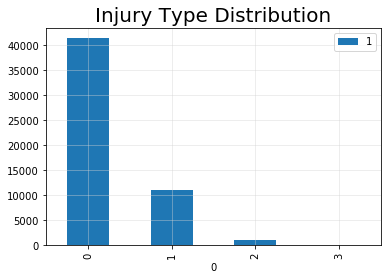

In [17]:
# dist plot *
plot = dist[[1]].plot(kind="bar");
plot.set_title("Injury Type Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [18]:
#over sampling 
from imblearn.over_sampling import SMOTE # uses KNN to generate new samples
from collections import Counter

X,y = data_to_reduce.drop('Injury Type',axis = 'columns'), data_to_reduce['Injury Type']

#Synthetic Minority Over-Sampling Technique
X_resampled, y_resampled = SMOTE().fit_resample(X,y)

In [20]:
# new distribution of target class

new_dist = Counter(y_resampled).items() #shows that there are equal amounts in each class
new_dist = pd.DataFrame(new_dist,index=['No Injury/Unknown','Non-incapacitating','Incapcitatin','Fatal'])
new_dist

,0,1
No Injury/Unknown,0,41400
Non-incapacitating,1,41400
Incapcitatin,2,41400
Fatal,3,41400


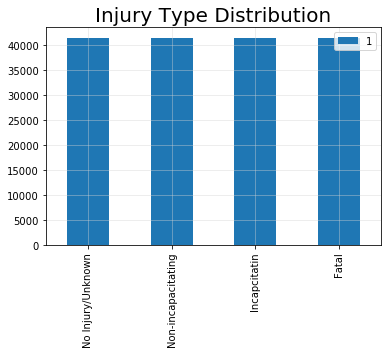

In [46]:
# new dist plot 
plot = new_dist[[1]].plot(kind="bar");
plot.set_title("Injury Type Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [28]:
res_data = pd.DataFrame(np.concatenate((X_resampled,y_resampled[:,np.newaxis]),axis = 1),columns = data_to_reduce.columns)

In [29]:
res_data

,Year,Month,Day,Hour,Injury Type,Severe Injury,Collision Type,Primary Factor,Weekend?
0,2015.000000,1.000000,5.000000,0.000000,0.0,1.000000,27.000000,0.000000,0.0
1,2015.000000,1.000000,6.000000,1500.000000,0.0,1.000000,11.000000,0.000000,0.0
2,2015.000000,1.000000,6.000000,2300.000000,0.0,1.000000,5.000000,1.000000,1.0
3,2015.000000,1.000000,7.000000,900.000000,0.0,1.000000,10.000000,1.000000,1.0
4,2015.000000,1.000000,7.000000,1100.000000,0.0,1.000000,10.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...
165595,2009.782063,7.130045,3.695964,200.000000,1.0,4.130045,41.474438,0.173991,3.0
165596,2010.142143,5.472071,3.614214,700.000000,1.0,1.000000,22.000000,0.000000,3.0
165597,2011.182235,10.000000,1.454314,300.000000,1.0,0.000000,34.638076,0.909137,3.0
165598,2014.629783,5.753188,2.876594,2212.340575,1.0,4.382971,38.000000,0.000000,3.0


In [38]:
#MCA multiple correspondence analysis 
mca = prince.MCA(n_components = 9,
                 n_iter = 5,
                 copy = True,
                 check_input = True,
                 engine = 'auto',
                 random_state = 42)
mca.fit(data_to_reduce)

MCA(check_input=True, copy=True, engine='auto', n_components=9, n_iter=5,
    random_state=42)

In [41]:
mca_components = mca.row_coordinates(data_to_reduce)
mca_components.head()

,0,1,2,3,4,5,6,7,8
0,0.010254,-0.012032,0.148043,-0.359361,0.362839,0.140440,-0.018660,0.433623,-0.228070
1,-0.243071,0.304482,-0.059903,-0.307947,0.091837,0.016260,0.570961,0.030233,0.038277
2,0.313232,-0.172154,-0.362397,0.217228,0.119744,0.137120,0.372286,-0.190211,0.413097
3,0.283253,-0.275326,-0.652550,0.018490,0.217099,0.129444,0.573883,0.109913,0.331202
4,0.249777,-0.353006,-0.764917,-0.401817,0.361672,0.107148,0.417306,-0.002028,0.222997


In [42]:
#contribution of each component to data
comp_percentages = pd.DataFrame(sorted(mca.explained_inertia_,reverse = True))
comp_percentages

,0
0,0.018691
1,0.017839
2,0.014578
3,0.012511
4,0.010988
5,0.009779
6,0.009550
7,0.009246
8,0.009171


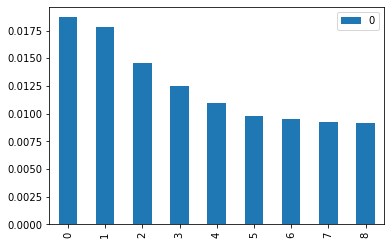

In [43]:
#plotting of components 
comp_percentages.plot(kind = 'bar')

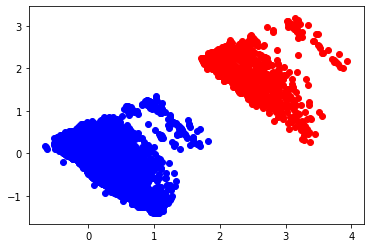

In [44]:
#scatter plot with first two components on Severe Injury
x1,y1 = mca_components[0][ndf['Severe Injury'] == 0],mca_components[1][ndf['Severe Injury'] == 0]
x2,y2 = mca_components[0][ndf['Severe Injury']==1],mca_components[1][ndf['Severe Injury'] == 1]

plt.scatter(x1,y1,color='blue')
plt.scatter(x2,y2,color='red')

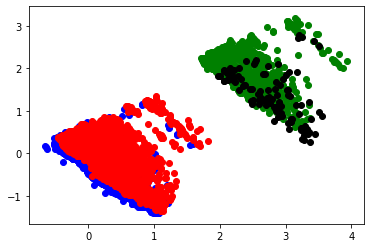

In [45]:
#scatter plot with first two components on Injury Type
x1,y1 = mca_components[0][ndf['Injury Type'] == 0],mca_components[1][ndf['Injury Type'] == 0]
x2,y2 = mca_components[0][ndf['Injury Type']==1],mca_components[1][ndf['Injury Type'] == 1]
x3,y3 = mca_components[0][ndf['Injury Type'] == 2],mca_components[1][ndf['Injury Type'] == 2]
x4,y4 = mca_components[0][ndf['Injury Type']==3],mca_components[1][ndf['Injury Type'] == 3]


plt.scatter(x1,y1,color='blue')
plt.scatter(x2,y2,color='red')
plt.scatter(x3,y3,color='green')
plt.scatter(x4,y4,color='black')

,ALCOHOLIC BEVERAGES,ANIMAL/OBJECT IN ROADWAY,BRAKE FAILURE OR DEFECTIVE,CELL PHONE USAGE,DISREGARD SIGNAL/REG SIGN,DRIVER ASLEEP OR FATIGUED,DRIVER DISTRACTED - EXPLAIN IN NARRATIVE,DRIVER ILLNESS,ENGINE FAILURE OR DEFECTIVE,FAILURE TO YIELD RIGHT OF WAY,...,TIRE FAILURE OR DEFECTIVE,TOW HITCH FAILURE,TRAFFIC CONTROL INOPERATIVE/MISSING/OBSC,UNSAFE BACKING,UNSAFE LANE MOVEMENT,UNSAFE SPEED,UTILITY WORK,VIEW OBSTRUCTED,VIOLATION OF LICENSE RESTRICTION,WRONG WAY ON ONE WAY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53939,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
53940,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [253]:
#Using Label-Encoded Injury Type as target and One-Hot encoded Primary Factor as features 
y = ndf['Injury Type']

rf_model = RandomForestClassifier(n_estimators = 15)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)
cross_val_score(rf_model,X_train,y_train,cv = 10)


array([0.77765487, 0.77350664, 0.77538036, 0.77614831, 0.77614831,
       0.77504151, 0.77614831, 0.773658  , 0.77353267, 0.77685493])

In [254]:
#Score
rf_model.fit(X_train,y_train)
rf_model.score(X_test,y_test)

0.7739018087855297

In [255]:
#Using new feature 'Severe Injury' as target and One-Hot encoded Primary Factor as features 
y2 = ndf['Severe Injury']

X_train, X_test, y_train, y_test = train_test_split(X,y2,test_size = 0.33)
cross_val_score(rf_model,X_train,y_train,cv = 10)


array([0.97786999, 0.97786999, 0.97786386, 0.97786386, 0.97786386,
       0.97786386, 0.97786386, 0.97786386, 0.97786386, 0.97813451])

In [256]:
#Score
rf_model.fit(X_train,y_train)
rf_model.score(X_test,y_test)

0.9772497472194136

In [854]:
#Same thing with logistic model 
lo_model = LogisticRegression()
cross_val_score(lo_model,X_train,y_train)

array([0.97734064, 0.97742176, 0.97741989])

In [855]:
#Score
lo_model.fit(X_train,y_train)
lo_model.score(X_test,y_test)

0.9782608695652174

In [282]:
#re-reducing data without targets 

data_to_reduce2 = data_to_reduce.drop(['Injury Type','Severe Injury'],axis = 'columns')

mca2 = prince.MCA(n_components = 6,
                 n_iter = 5,
                 copy = True,
                 check_input = True,
                 engine = 'auto',
                 random_state = 42)
mca2.fit(data_to_reduce2)


MCA(check_input=True, copy=True, engine='auto', n_components=6, n_iter=5,
    random_state=42)

In [283]:
#mca components 2
mca_components2 = mca2.row_coordinates(data_to_reduce2)
mca_components2.head()

,0,1,2,3,4,5
0,0.018815,0.201424,-0.159177,-0.072378,0.167275,-0.092681
1,-0.456599,-0.060549,-0.084719,-0.334794,-0.409212,-0.209881
2,0.390715,-0.375347,0.317991,-0.222528,0.534932,-0.117744
3,0.465596,-0.703420,-0.003108,-0.665438,0.270988,-0.209745
4,0.492856,-0.883094,0.083809,-0.573134,0.152959,-0.022838


In [292]:
X2 = mca_components2.iloc[:,:3]
y3 = data_to_reduce['Injury Type']
y4 = data_to_reduce['Severe Injury']

In [293]:
#new model with reduced data excluding targets. target value = Injury Type
rf_model2 = RandomForestClassifier(n_estimators = 15)

X_train, X_test, y_train, y_test = train_test_split(X2,y3,test_size = 0.33)
cross_val_score(rf_model,X_train,y_train,cv = 10)

array([0.74812552, 0.75145793, 0.75111111, 0.74666667, 0.7477077 ,
       0.75382051, 0.75104196, 0.75152863, 0.74895746, 0.75201557])

In [294]:
#Target value = Severe Injury 
X_train, X_test, y_train, y_test = train_test_split(X2,y4,test_size = 0.33)
cross_val_score(rf_model,X_train,y_train,cv = 10)

array([0.97611111, 0.97611111, 0.97722222, 0.97472222, 0.97666667,
       0.97638233, 0.97526404, 0.97470817, 0.97693163, 0.97609783])

In [295]:
#new logistic regression model with reduced data excluding targets. target value = Injury Type
lo_model2 = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X2,y3,test_size = 0.33)
cross_val_score(lo_model2,X_train,y_train,cv = 10)

array([0.77867259, 0.7814496 , 0.7814496 , 0.77993887, 0.781606  ,
       0.77910531, 0.7823791 , 0.7815453 , 0.78182324, 0.77787045])

In [296]:
#Target = Severe Type
X_train, X_test, y_train, y_test = train_test_split(X2,y4,test_size = 0.33)
cross_val_score(lo_model2,X_train,y_train,cv = 10)

array([0.97638889, 0.97638889, 0.97666018, 0.97666018, 0.97666018,
       0.97666018, 0.97666018, 0.97666018, 0.97666018, 0.9766537 ])

In [312]:
data.columns

Index(['Year', 'Month', 'Day', 'Weekend?', 'Hour', 'Collision Type',
       'Injury Type', 'Primary Factor', 'Reported_Location', 'Latitude',
       'Longitude'],
      dtype='object')

In [49]:

#5 droping unnecessary cols
df2 = data.drop(['Year', 'Month', 'Day', 'Weekend?','Hour','Primary Factor','Reported_Location','Latitude',
       'Longitude'],axis = 1)

df2

,Collision Type,Injury Type
0,2-Car,No injury/unknown
1,2-Car,No injury/unknown
2,2-Car,Non-incapacitating
3,2-Car,Non-incapacitating
4,2-Car,No injury/unknown
...,...,...
53344,1-Car,No injury/unknown
53345,1-Car,Non-incapacitating
53346,1-Car,No injury/unknown
53347,1-Car,Non-incapacitating


In [50]:

#7 encoding Collision Type and Injury Type

#a Collision Types - one-hot encoding 

collision_types = pd.get_dummies(df2['Collision Type'])

#print(collision_types)

df2 = pd.concat([df2,collision_types],axis = 'columns')

df2

,Collision Type,Injury Type,1-Car,2-Car,3+ Cars,Bus,Cyclist,Moped/Motorcycle,Pedestrian
0,2-Car,No injury/unknown,0,1,0,0,0,0,0
1,2-Car,No injury/unknown,0,1,0,0,0,0,0
2,2-Car,Non-incapacitating,0,1,0,0,0,0,0
3,2-Car,Non-incapacitating,0,1,0,0,0,0,0
4,2-Car,No injury/unknown,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
53344,1-Car,No injury/unknown,1,0,0,0,0,0,0
53345,1-Car,Non-incapacitating,1,0,0,0,0,0,0
53346,1-Car,No injury/unknown,1,0,0,0,0,0,0
53347,1-Car,Non-incapacitating,1,0,0,0,0,0,0


In [51]:

#b droping original column and one dependent column
df2 = df2.drop(['Collision Type','Bus'],axis = 1)


In [52]:
#c2 Injury Type One-Hot Encoding 
injury_types = pd.get_dummies(df2['Injury Type'],drop_first = True)

df2 = pd.concat([df2,injury_types],axis = 'columns')

df2 = df2.drop('Injury Type', axis = 'columns')

df2.head()

,1-Car,2-Car,3+ Cars,Cyclist,Moped/Motorcycle,Pedestrian,Incapacitating,No injury/unknown,Non-incapacitating
0,0,1,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1,0


In [53]:
df3 = data.drop(['Reported_Location','Injury Type','Collision Type','Primary Factor'],axis = 'columns')

In [54]:
df3 = pd.concat([df3,df2], axis = 'columns').dropna()
df3 

,Year,Month,Day,Weekend?,Hour,Latitude,Longitude,1-Car,2-Car,3+ Cars,Cyclist,Moped/Motorcycle,Pedestrian,Incapacitating,No injury/unknown,Non-incapacitating
0,2015,1,5,0,0.0,39.159207,-86.525874,0,1,0,0,0,0,0,1,0
1,2015,1,6,0,1500.0,39.161440,-86.534848,0,1,0,0,0,0,0,1,0
2,2015,1,6,1,2300.0,39.149780,-86.568890,0,1,0,0,0,0,0,0,1
3,2015,1,7,1,900.0,39.165655,-86.575956,0,1,0,0,0,0,0,0,1
4,2015,1,7,1,1100.0,39.164848,-86.579625,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53344,2003,4,7,1,2000.0,39.004275,-86.581375,1,0,0,0,0,0,0,1,0
53345,2003,5,7,1,1500.0,39.002752,-86.463856,1,0,0,0,0,0,0,0,1
53346,2003,11,3,0,2300.0,38.992326,-86.537252,1,0,0,0,0,0,0,1,0
53347,2003,12,7,1,1700.0,38.991520,-86.448784,1,0,0,0,0,0,0,0,1


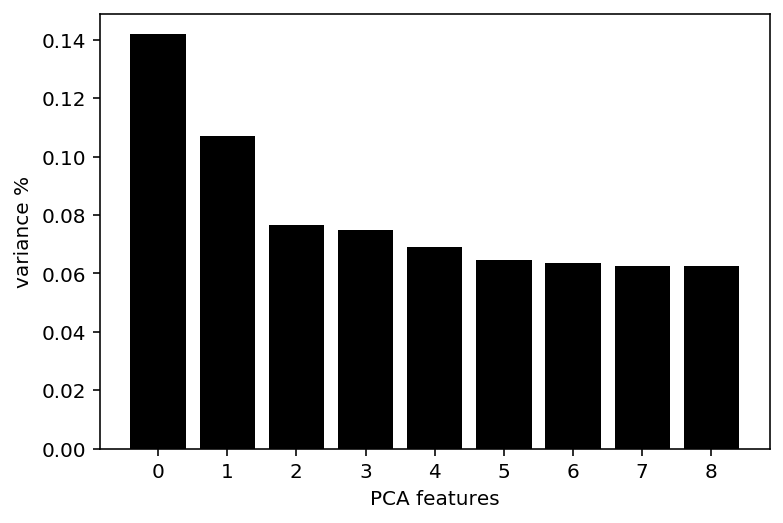

In [56]:
#CLUSTERSING=================PCAs========================
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# Standardize the data to have a mean of ~0 and a variance of 1
std_data = StandardScaler().fit_transform(df3)

# Create a PCA instance: pca
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(std_data)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
pca_components = pd.DataFrame(principalComponents)

In [57]:
pca_components

,0,1,2,3,4,5,6,7,8
0,-1.098969,0.332479,0.342553,0.559211,-0.928534,0.750148,-1.379964,-0.977443,1.015286
1,-1.162445,-0.224967,0.127095,0.874553,0.155931,0.665289,-0.850121,-1.211949,0.400172
2,1.547623,-1.749668,-1.761746,1.137266,0.138403,0.531925,-0.631075,-1.423704,0.376730
3,1.593017,-1.202646,-2.196522,1.137994,-0.680848,0.835034,-1.014450,-1.071168,0.867775
4,-1.108001,0.211799,-1.663167,1.718196,0.038165,0.694171,-0.800247,-1.169802,0.596735
...,...,...,...,...,...,...,...,...,...
48780,0.330009,2.311091,-2.386408,-0.081818,0.311570,-1.501435,-0.650554,-1.887129,0.539243
48781,3.051026,1.009203,-2.920634,-0.674832,-0.575029,-1.388023,-0.803749,-1.587005,0.991388
48782,0.332971,1.849165,0.456602,-1.323692,0.097998,-2.020955,0.351280,-1.049596,-0.110405
48783,3.088131,0.914294,-2.826962,-0.585379,-0.403626,-1.781289,0.400148,-0.876505,0.465599


Text(0, 0.5, '2nd component')

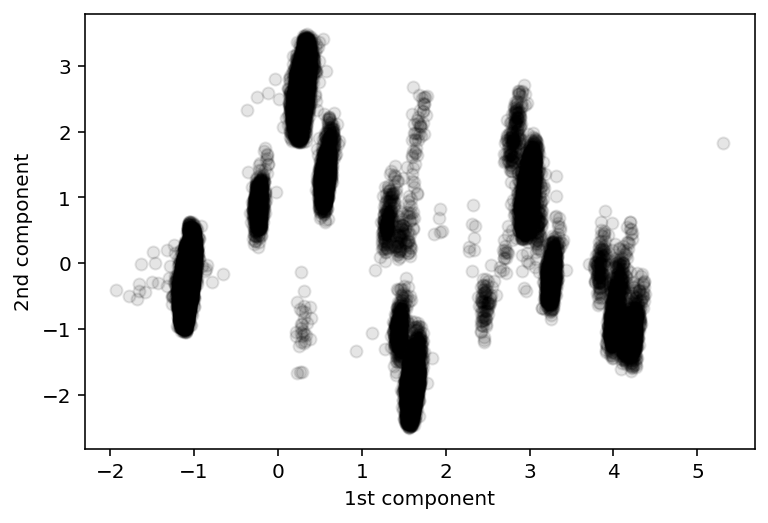

In [58]:
#++++++++++++++++++++++++PCA SCatter PLot==================
plt.scatter(mca_components[0], mca_components[1], alpha=.1, color='black')
plt.xlabel('1st component')
plt.ylabel('2nd component')

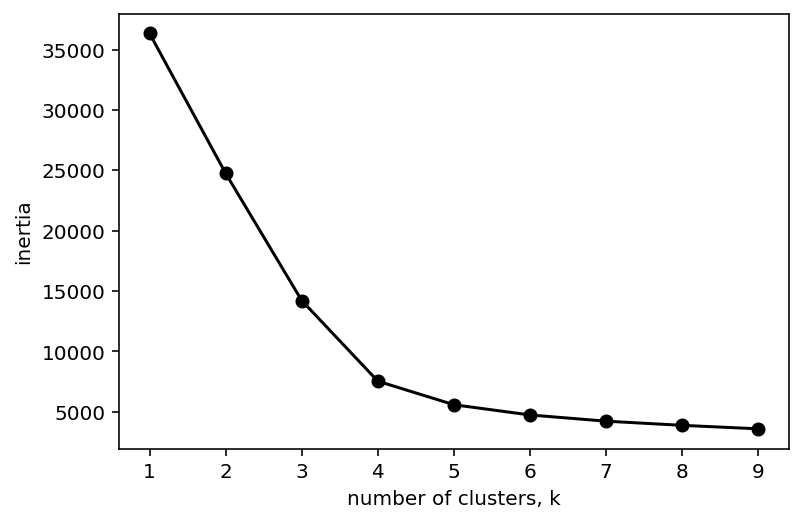

In [59]:
#======================PCA ELBOW DEF==================
k_num = range(1, 10)
inertias = []
for k in k_num:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(mca_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(k_num, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(k_num)
plt.show()

In [60]:
km_model = KMeans(n_clusters=4)

In [61]:
predicted = km_model.fit_predict(std_data[:,:14])
predicted

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [62]:
df3['Cluster'] = predicted
df3.head()

,Year,Month,Day,Weekend?,Hour,Latitude,Longitude,1-Car,2-Car,3+ Cars,Cyclist,Moped/Motorcycle,Pedestrian,Incapacitating,No injury/unknown,Non-incapacitating,Cluster
0,2015,1,5,0,0.0,39.159207,-86.525874,0,1,0,0,0,0,0,1,0,0
1,2015,1,6,0,1500.0,39.161440,-86.534848,0,1,0,0,0,0,0,1,0,0
2,2015,1,6,1,2300.0,39.149780,-86.568890,0,1,0,0,0,0,0,0,1,0
3,2015,1,7,1,900.0,39.165655,-86.575956,0,1,0,0,0,0,0,0,1,0
4,2015,1,7,1,1100.0,39.164848,-86.579625,0,1,0,0,0,0,0,1,0,0


mca_components.shape

In [ ]:
km_model.score()

In [357]:
t = mca_components

t['Cluster'] = pd.Series(predicted)
t

,0,1,2,3,4,5,6,7,8,Cluster
0,0.010254,-0.012032,0.148043,-0.359361,0.362839,0.140440,-0.018660,0.433623,-0.228070,1.0
1,-0.243071,0.304482,-0.059903,-0.307947,0.091837,0.016260,0.570961,0.030233,0.038277,1.0
2,0.313232,-0.172154,-0.362397,0.217228,0.119744,0.137120,0.372286,-0.190211,0.413097,1.0
3,0.283253,-0.275326,-0.652550,0.018490,0.217099,0.129444,0.573883,0.109913,0.331202,1.0
4,0.249777,-0.353006,-0.764917,-0.401817,0.361672,0.107148,0.417306,-0.002028,0.222997,1.0
...,...,...,...,...,...,...,...,...,...,...
53938,-0.361533,0.123666,-0.163884,-0.235948,0.063994,-0.001053,0.018288,-0.462380,0.388442,NaN
53939,0.028452,-0.089550,0.799674,-0.045692,-0.294350,0.329803,0.169493,-0.418406,0.548985,NaN
53940,-0.329149,0.096925,0.050671,-0.141574,0.003150,0.053310,-0.112915,-0.225339,-0.281662,NaN
53941,0.084382,-0.517989,-0.295049,-0.472955,0.434620,0.328137,0.068412,0.060179,0.410711,NaN


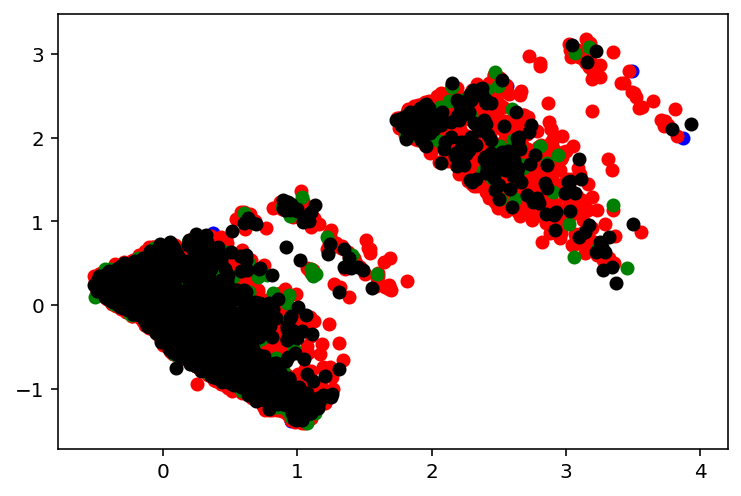

In [358]:
#===========================CLUSTERS+++++++++========================
c1 = t[t['Cluster']==0]
c2 = t[t['Cluster']==1]
c3 = t[t['Cluster']==2]
c4 = t[t['Cluster']==3]
#c5 = t[t['Cluster']==4]
#c6 = t[t['Cluster']==5]
#c7 = t[t['Cluster']==6]


#plotting clusters
plt.scatter(c1[0],c1[1],color='blue')
plt.scatter(c2[0],c2[1],color='red')
plt.scatter(c3[0],c3[1],color='green')
plt.scatter(c4[0],c4[1],color='black')
#plt.scatter(c5[0],c5[1],color='orange')
#plt.scatter(c6[0],c6[1],color='purple')
#plt.scatter(c7[0],c7[1],color='yellow')

plt.show()

In [360]:
#===============================Descriptive Statistics======================

#1 general descriptive analysis 
df3.describe()#for report

,Year,Month,Day,Hour,Latitude,Longitude,1-Car,2-Car,3+ Cars,Cyclist,Moped/Motorcycle,Pedestrian,Incapacitating,No injury/unknown,Non-incapacitating,Primary Factor,Cluster
count,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000
mean,2009.066311,6.646428,4.198832,1348.475966,39.164913,-86.534284,0.185344,0.698616,0.059752,0.009183,0.019022,0.012073,0.020437,0.764354,0.212996,22.667480,1.421257
std,3.770507,3.518319,1.908617,533.016756,0.049638,0.785346,0.388580,0.458864,0.237029,0.095389,0.136604,0.109215,0.141490,0.424406,0.409429,16.115114,0.795529
min,2003.000000,1.000000,1.000000,0.000000,38.019328,-88.959213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,4.000000,3.000000,1000.000000,39.153408,-86.556713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10.000000,1.000000
50%,2009.000000,7.000000,4.000000,1400.000000,39.164656,-86.533424,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,16.000000,1.000000
75%,2012.000000,10.000000,6.000000,1700.000000,39.175571,-86.517506,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,38.000000,1.000000
max,2015.000000,12.000000,7.000000,2300.000000,41.228665,86.596363,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,55.000000,3.000000


In [361]:
#2 mode of each category
for i in data.columns:
	print(i,":",data[i].mode()) #for report


Year : 0    2008
dtype: int64
Month : 0    10
dtype: int64
Day : 0    6
dtype: int64
Weekend? : 0    0
dtype: object
Hour : 0    1700.0
dtype: float64
Collision Type : 0    2-Car
dtype: object
Injury Type : 0    No injury/unknown
dtype: object
Primary Factor : 0    FAILURE TO YIELD RIGHT OF WAY
dtype: object
Reported_Location : 0    E 3RD ST
dtype: object
Latitude : 0    39.16424
dtype: float64
Longitude : 0   -86.5336
dtype: float64


In [890]:
# Covariance matrix 
df3.cov()# for report 

,Year,Month,Day,Hour,Latitude,Longitude,1-Car,2-Car,3+ Cars,Cyclist,Moped/Motorcycle,Pedestrian,Incapacitating,No injury/unknown,Non-incapacitating,Primary Factor,Cluster
Year,14.102511,-0.162483,-0.037598,-36.979413,0.000105,0.014207,0.065145,-0.102232,-0.011202,0.013405,0.009933,0.019474,0.054467,0.074613,-0.128588,-1.889800,0.089943
Month,-0.162483,12.364685,-0.057022,20.046936,0.000769,0.008567,0.002247,-0.013704,0.001527,0.006394,0.008117,0.003004,0.005683,-0.018318,0.012949,-0.086852,0.023023
Day,-0.037598,-0.057022,3.633487,7.978857,0.000309,-0.008699,-0.005873,0.006346,0.005681,-0.002134,-0.003649,0.001410,-0.002969,0.005631,-0.003066,0.013361,0.000240
Hour,-36.979413,20.046936,7.978857,281722.016728,0.005700,0.329852,-26.572368,21.628625,2.490814,0.687672,1.441277,0.753745,0.301520,-3.163673,3.665130,-298.858751,-19.475531
Latitude,0.000105,0.000769,0.000309,0.005700,0.002496,0.000018,-0.000162,0.000264,-0.000056,0.000012,-0.000106,0.000012,-0.000012,0.000303,-0.000265,0.000521,-0.000367
Longitude,0.014207,0.008567,-0.008699,0.329852,0.000018,0.629270,-0.000718,-0.002736,0.003340,0.000062,0.000004,0.000019,0.003432,-0.002202,-0.001198,-0.015478,0.006045
1-Car,0.065145,0.002247,-0.005873,-26.572368,-0.000162,-0.000718,0.151441,-0.129627,-0.011238,-0.001724,-0.003592,-0.002257,0.000018,-0.000128,-0.000390,0.771735,0.121144
2-Car,-0.102232,-0.013704,0.006346,21.628625,0.000264,-0.002736,-0.129627,0.211314,-0.042082,-0.006455,-0.013449,-0.008451,-0.005986,0.033913,-0.026960,-0.754990,-0.243079
3+ Cars,-0.011202,0.001527,0.005681,2.490814,-0.000056,0.003340,-0.011238,-0.042082,0.056754,-0.000560,-0.001166,-0.000733,0.000960,-0.010873,0.009945,-0.063465,0.099730
Cyclist,0.013405,0.006394,-0.002134,0.687672,0.000012,0.000062,-0.001724,-0.006455,-0.000560,0.009179,-0.000179,-0.000112,0.000790,-0.005880,0.005111,-0.005492,0.006033


In [891]:
#4 Correlation matrix
df3.corr()# for report

,Year,Month,Day,Hour,Latitude,Longitude,1-Car,2-Car,3+ Cars,Cyclist,Moped/Motorcycle,Pedestrian,Incapacitating,No injury/unknown,Non-incapacitating,Primary Factor,Cluster
Year,1.000000,-0.012305,-0.005252,-0.018552,0.000559,0.004769,0.044577,-0.059221,-0.012522,0.037257,0.019224,0.047370,0.101605,0.046590,-0.083222,-0.061647,0.040602
Month,-0.012305,1.000000,-0.008507,0.010741,0.004376,0.003071,0.001642,-0.008478,0.001823,0.018978,0.016776,0.007804,0.011323,-0.012216,0.008950,-0.003026,0.011099
Day,-0.005252,-0.008507,1.000000,0.007886,0.003242,-0.005753,-0.007917,0.007242,0.012510,-0.011684,-0.013915,0.006760,-0.010912,0.006927,-0.003909,0.000859,0.000214
Hour,-0.018552,0.010741,0.007886,1.000000,0.000215,0.000783,-0.128646,0.088645,0.019699,0.013523,0.019735,0.012972,0.003980,-0.013977,0.016783,-0.068976,-0.062202
Latitude,0.000559,0.004376,0.003242,0.000215,1.000000,0.000454,-0.008334,0.011479,-0.004681,0.002530,-0.015454,0.002190,-0.001641,0.014215,-0.012876,0.001276,-0.012458
Longitude,0.004769,0.003071,-0.005753,0.000783,0.000454,1.000000,-0.002326,-0.007502,0.017674,0.000822,0.000037,0.000218,0.030304,-0.006509,-0.003670,-0.002390,0.012918
1-Car,0.044577,0.001642,-0.007917,-0.128646,-0.008334,-0.002326,1.000000,-0.724617,-0.121219,-0.046235,-0.067078,-0.052980,0.000330,-0.000774,-0.002435,0.242934,0.527721
2-Car,-0.059221,-0.008478,0.007242,0.088645,0.011479,-0.007502,-0.724617,1.000000,-0.384270,-0.146566,-0.212639,-0.167947,-0.091225,0.172993,-0.142540,-0.201196,-0.896416
3+ Cars,-0.012522,0.001823,0.012510,0.019699,-0.004681,0.017674,-0.121219,-0.384270,1.000000,-0.024519,-0.035572,-0.028095,0.028230,-0.107021,0.101456,-0.032635,0.709668
Cyclist,0.037257,0.018978,-0.011684,0.013523,0.002530,0.000822,-0.046235,-0.146566,-0.024519,1.000000,-0.013568,-0.010716,0.057776,-0.143909,0.129645,-0.007022,0.106740


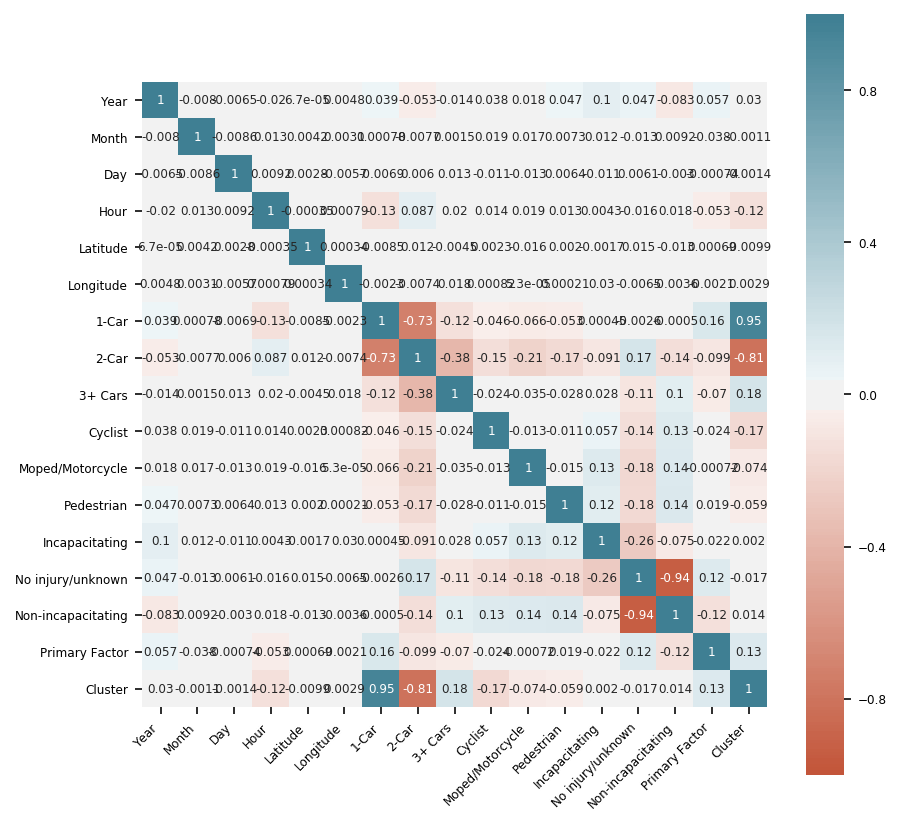

In [362]:
#==============================Figures=========================================
# Heatmap

cor = df3.corr()

plt.figure(figsize = (7,7))
plt.rcParams.update({'font.size': 6})

ax = sns.heatmap(
    cor,
    annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

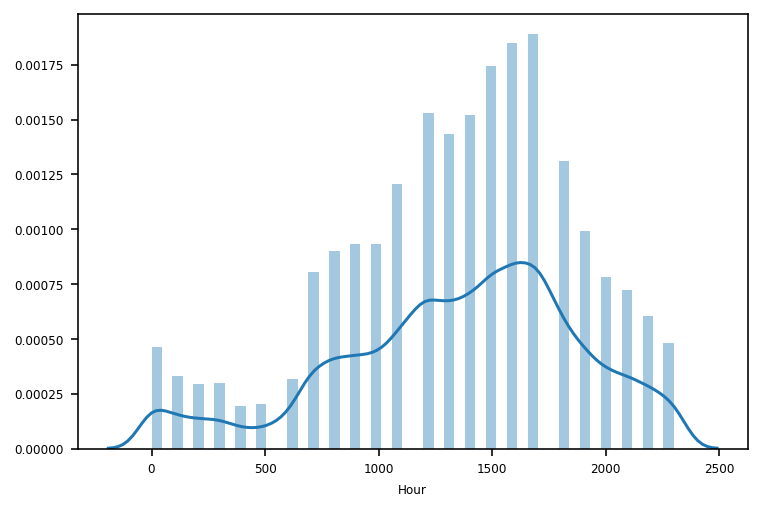

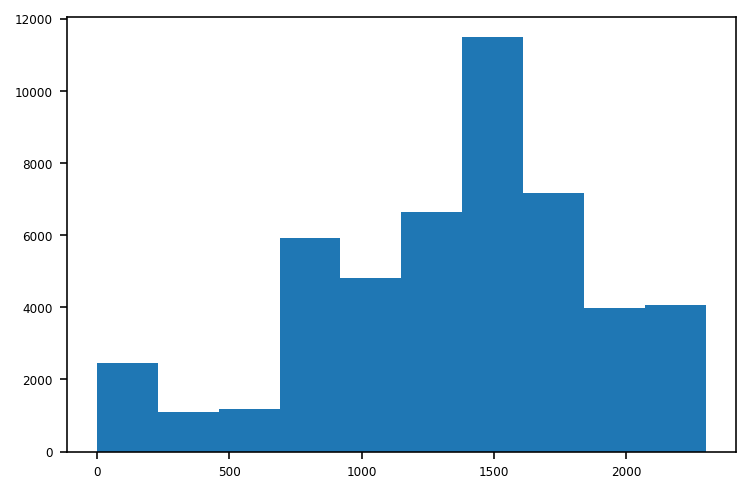

In [363]:
# Histograms
sns.distplot(data['Hour'])
plt.show()
plt.hist(data['Hour'])
plt.show()

In [364]:
#===============================New Prediction Using Clusters====================

new_df = df3[['1-Car','2-Car','3+ Cars','Cluster','Primary Factor']]

In [365]:
X, y = new_df[['1-Car','2-Car','3+ Cars']], new_df['Cluster']

In [368]:
from sklearn.svm import SVC
svm_model = SVC(kernel = 'sigmoid')

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)
cross_val_score(svm_model,X_train,y_train,cv = 10)

array([0.99143993, 0.99143731, 0.99143731, 0.99143469, 0.99143469,
       0.99143207, 0.99173554, 0.99173554, 0.99173554, 0.99173554])

In [370]:
svm_model.fit(X_train,y_train)
svm_model.score(X_test,y_test)

0.9893167701863355

In [371]:
new_df['Injury Type'] = ndf['Injury Type']

In [372]:
new_df.corr()

,1-Car,2-Car,3+ Cars,Cluster,Primary Factor,Injury Type
1-Car,1.000000,-0.726209,-0.120242,0.946590,0.155665,0.007482
2-Car,-0.726209,1.000000,-0.383808,-0.806222,-0.098739,-0.183593
3+ Cars,-0.120242,-0.383808,1.000000,0.183396,-0.070127,0.099505
Cluster,0.946590,-0.806222,0.183396,1.000000,0.134082,0.020345
Primary Factor,0.155665,-0.098739,-0.070127,0.134082,1.000000,-0.108477
Injury Type,0.007482,-0.183593,0.099505,0.020345,-0.108477,1.000000


In [390]:
X,y = new_df[['1-Car','2-Car','3+ Cars','Primary Factor']], new_df['Injury Type']

In [391]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)
cross_val_score(RandomForestClassifier(),X_train,y_train,cv = 10)

array([0.78018954, 0.78158458, 0.78189049, 0.78036097, 0.78189049,
       0.78274174, 0.78059976, 0.78212974, 0.77869605, 0.7771656 ])

In [392]:
new_df['Severe Injury'] = ndf['Severe Injury']

In [393]:
X,y = new_df[['2-Car','3+ Cars','Primary Factor']], new_df['Severe Injury']

In [395]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,test_size = 0.33)
cross_val_score(RandomForestClassifier(),X_train2,y_train2,cv = 10)

array([0.97828746, 0.97798165, 0.97858672, 0.97858017, 0.97858017,
       0.97858017, 0.97858017, 0.97858017, 0.97858017, 0.97858017])

In [396]:
#=====================Neural Network==================
from sklearn.neural_network import MLPClassifier

In [397]:
len(X)

48785

In [398]:
nn_model = MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
                         beta_1=0.9, beta_2=0.999, early_stopping=False,
                         epsilon=1e-08, hidden_layer_sizes=(5, 2),
                         learning_rate_init=0.001,
                         max_iter=200,random_state=1)

In [399]:
cross_val_score(nn_model,X_train,y_train,cv = 10)

array([0.77438092, 0.77760783, 0.77607831, 0.77669012, 0.77730193,
       0.77662179, 0.77662179, 0.77662179, 0.77134986, 0.77104377])

In [1051]:
nn_model.fit(X_train,y_train)
nn_model.score(X_test,y_test)


0.9785157487800241

In [1012]:
#++++++++++++++KNN CLASSIFIER+++++++++++++++++++++++++++
from sklearn.neighbors import KNeighborsClassifier

In [1043]:
knn_model = KNeighborsClassifier(n_neighbors = 200)

In [1046]:
cross_val_score(knn_model,X_train,y_train,cv = 10)

array([0.97597504, 0.97596754, 0.97596754, 0.97596754, 0.97627224,
       0.97627224, 0.97627224, 0.97627224, 0.97627224, 0.97627224])

In [1047]:
knn_model.fit(X_train,y_train)
knn_model.score(X_test,y_test)

0.9785157487800241